In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import os

In [3]:
os.getcwd()

'/home/dhcoe/projects/mlcourse/src'

In [6]:
train=pd.read_csv("../input/ods-mlclass-dubai-2019-03-lecture3-hw/train.csv")
test=pd.read_csv("../input/ods-mlclass-dubai-2019-03-lecture3-hw/test.csv")
test["target"]=-1
data=pd.concat([train,test],ignore_index=True)
data.target.value_counts()

 0    24720
-1    16281
 1     7841
Name: target, dtype: int64

In [7]:

continuous=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
target=["target"]
id=["uid"]
train.columns
categorical=['workclass','marital-status', 'occupation', 'relationship', 'race','sex', 'native-country','education']

In [8]:
data.describe()

,uid,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
count,48842.000000,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,24421.166680,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,-0.172802
std,14100.385087,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.681195
min,0.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,-1.000000
25%,12210.250000,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,-1.000000
50%,24420.500000,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,36632.750000,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,48843.000000,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


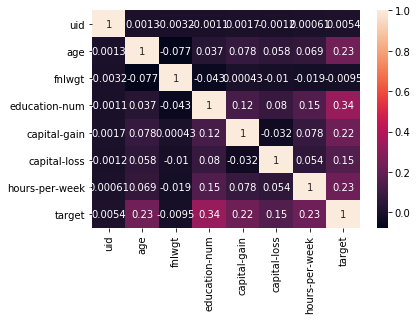

In [9]:
import seaborn as sns

sns.heatmap(train.corr(),annot = True)

In [10]:
dummies=pd.get_dummies(data[categorical])
dcols=dummies.columns
print(data.shape)
data=data.merge(dummies,how='left',left_index=True,right_index=True)
print(data.shape)

(48842, 16)
(48842, 118)


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
uid,48842.0,24421.166680,14100.385087,0.0,12210.25,24420.5,36632.75,48843.0
age,48842.0,38.643585,13.710510,17.0,28.00,37.0,48.00,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.50,178144.5,237642.00,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.00,10.0,12.00,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.00,0.0,0.00,99999.0
...,...,...,...,...,...,...,...,...
education_ HS-grad,48842.0,0.323164,0.467690,0.0,0.00,0.0,1.00,1.0
education_ Masters,48842.0,0.054400,0.226807,0.0,0.00,0.0,0.00,1.0
education_ Preschool,48842.0,0.001699,0.041189,0.0,0.00,0.0,0.00,1.0
education_ Prof-school,48842.0,0.017075,0.129554,0.0,0.00,0.0,0.00,1.0


In [12]:
train=data[data["target"]!=-1]
test=data[data["target"]==-1]
len(train),len(test)

(32561, 16281)

In [15]:
%%time
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
X=train.drop(target+id+categorical,axis=1).values
y=train.target.values

scorer=make_scorer(log_loss, greater_is_better=False)

params = {'n_neighbors':[3,5,11,19], 'weights': ['uniform','distance'],\
'metric':['euclidean','manhattan']}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3,n_jobs=-1 ,scoring=scorer)
grid_search_cv.fit(X, y)
grid_search_cv.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    6.8s finished
CPU times: user 706 ms, sys: 32.5 ms, total: 738 ms
Wall time: 7.37 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='distance')

In [28]:
%%time
from xgboost import XGBClassifier
NFOLDS=5
skf = StratifiedKFold(n_splits=NFOLDS)
X=train.drop(target+id+categorical,axis=1).values
y=train.target.values

X_test=test.drop(id+target+categorical,axis=1).values
preds=np.zeros((X_test.shape[0],))
losses=[]
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # print(X_train.shape,X_val.shape)
    # clf=grid_search_cv.best_estimator_
    clf=XGBClassifier()
        
    clf.fit(X_train,y_train)
    pval=clf.predict_proba(X_val)[:,1]
    loss=log_loss(y_val,pval)
    losses.append(loss)
    
    pred_test=clf.predict_proba(X_test)[:,1]
    preds+=pred_test
print(np.mean(losses))
preds=preds/NFOLDS
sub=pd.DataFrame()
sub["uid"]=test.reset_index()["uid"]

sub["target"]= preds
sub.head()
# sub.to_csv("submit_hyp_opt1.csv",index=None)

0.28050189479494947
CPU times: user 1min 6s, sys: 819 ms, total: 1min 7s
Wall time: 5.71 s


,uid,target
0,32563,0.001370
1,32564,0.218580
2,32565,0.377446
3,32566,0.998731
4,32567,0.000081


In [29]:


X=train.drop(target+id+categorical,axis=1).values
y=train.target.values

scorer=make_scorer(log_loss, greater_is_better=False)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid_search_cv = GridSearchCV(XGBClassifier(), params, verbose=1, cv=3,n_jobs=-1 ,scoring=scorer)
grid_search_cv.fit(X, y)
grid_search_cv.best_estimator_

from xgboost import XGBClassifier
NFOLDS=5
skf = StratifiedKFold(n_splits=NFOLDS)
X=train.drop(target+id+categorical,axis=1).values
y=train.target.values

X_test=test.drop(target+id+categorical,axis=1).values
preds=np.zeros((X_test.shape[0],))
losses=[]
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # print(X_train.shape,X_val.shape)
    clf=grid_search_cv.best_estimator_
    # clf=XGBClassifier()
        
    clf.fit(X_train,y_train)
    pval=clf.predict_proba(X_val)[:,1]
    loss=log_loss(y_val,pval)
    losses.append(loss)
    
    pred_test=clf.predict_proba(X_test)[:,1]
    preds+=pred_test
print(np.mean(losses))
preds=preds/NFOLDS
sub=pd.DataFrame()
sub["uid"]=test.reset_index()["uid"]

sub["target"]= preds
sub.head()
# sub.to_csv("submit_hyp_opt1.csv",index=None)


Fitting 3 folds for each of 1764 candidates, totalling 5292 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 5269 out of 5292 | elapsed:   44.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 5292 out of 5292 | elapsed:   45.0s finished
0.3283041933531944


,uid,target
0,32563,0.010694
1,32564,0.234129
2,32565,0.253303
3,32566,0.979188
4,32567,0.010694


In [52]:
from sklearn.metrics import log_loss
NFOLDS=5
skf = StratifiedKFold(n_splits=NFOLDS)
X=train.drop(target+id+categorical+continuous,axis=1).values
y=train.target.values

X_test=test.drop(id+target+categorical+continuous,axis=1).values
preds=np.zeros((X_test.shape[0],))
losses=[]
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # print(X_train.shape,X_val.shape)
    clf=DecisionTreeClassifier( criterion='gini',
    splitter='best',
    max_depth=8,
    min_samples_split=42,
    min_samples_leaf=17)
    clf.fit(X_train,y_train)
    pval=clf.predict_proba(X_val)[:,1]
    loss=log_loss(y_val,pval)
    print(loss)
    losses.append(loss)
    
    pred_test=clf.predict_proba(X_test)[:,1]
    preds+=pred_test
print(f"Final ; {np.mean(losses)}")
preds=preds/NFOLDS
sub=pd.DataFrame()
sub["uid"]=test.reset_index()["uid"]

sub["target"]= preds
sub.head()



0.3858289523296494
0.3884464920403026
0.39231183213972276
0.37528430974929966
0.3884635727981928
Final ; 0.3860670318114335


,uid,target
0,32563,0.003848
1,32564,0.252239
2,32565,0.232298
3,32566,0.339217
4,32567,0.003848


Final ; 0.4465994106398791
Final ; 0.3919029242304849
Final ; 0.3587819032219118
Final ; 0.35148509942338746
Final ; 0.3407133843951013
Final ; 0.33345465911747174
Final ; 0.3319521948437245
Final ; 0.3318839023465698
Final ; 0.3443188881688788
Final ; 0.36827498047895457
Final ; 0.4116076208363985
Final ; 0.4522590329815054
Final ; 0.513642849486534
Final ; 0.5585211281108106
Final ; 0.5914632342849303
Final ; 0.6367160926964439
Final ; 0.652261653169315
Final ; 0.6724091830413412
Final ; 0.6749888688386235
Final ; 0.6925825824554124
          losses
depths          
1       0.446599
2       0.391903
3       0.358782
4       0.351485
5       0.340713
6       0.333455
7       0.331952
8       0.331884
9       0.344319
10      0.368275
11      0.411608
12      0.452259
13      0.513643
14      0.558521
15      0.591463
16      0.636716
17      0.652262
18      0.672409
19      0.674989
20      0.692583


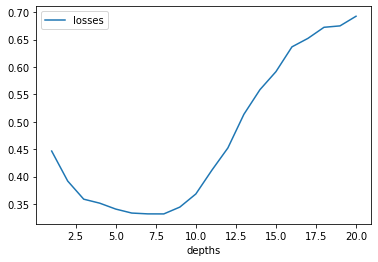

In [75]:

depths=[i+1 for i in range(20)]
all_losses=[]
for d in depths:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=d,
        min_samples_split=42,
        min_samples_leaf=17)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    print(f"Final ; {np.mean(losses)}")
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":depths,"losses":all_losses}).set_index("depths")
print(tdf)
tdf.plot()

losses
depths          
0.01    0.325621
0.02    0.324368
0.03    0.324104
0.04    0.321733
0.05    0.322286
...          ...
0.95    0.446599
0.96    0.446599
0.97    0.446599
0.98    0.446599
0.99    0.446599

[99 rows x 1 columns]


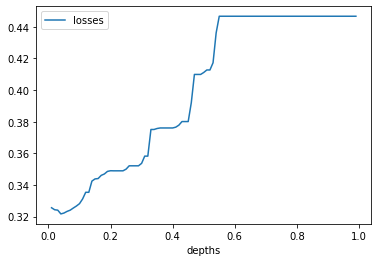

In [84]:

samplesplit=[(i)/100 for i in range(1,100)]
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=d,
        min_samples_leaf=17)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
tdf.plot()

In [88]:
tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()]

(0.3217326492108173,
           losses
 depths          
 0.04    0.321733)

losses
depths          
1       0.324591
2       0.321524
3       0.321597
4       0.321597
5       0.321481
...          ...
95      0.322922
96      0.322922
97      0.322922
98      0.322922
99      0.322923

[99 rows x 1 columns]
0.32116156157295406           losses
depths          
33      0.321162


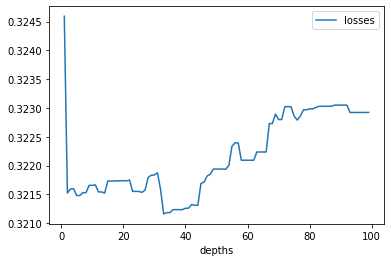

In [89]:

samplesplit=[i for i in range(1,100)]
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])
tdf.plot()

losses
depths          
0.01    0.514353
0.02    0.465854
0.03    0.442366
0.04    0.443797
0.05    0.431880
...          ...
0.95    0.321242
0.96    0.321152
0.97    0.321640
0.98    0.321234
0.99    0.321530

[99 rows x 1 columns]


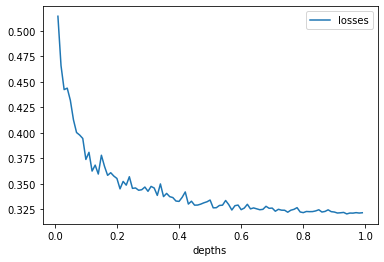

In [91]:

samplesplit=[(i)/100 for i in range(1,100)]
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
tdf.plot()

In [92]:
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])

0.3203910750767238           losses
depths          
0.94    0.320391


losses
depths          
sqrt    0.394227
NaN     0.321162
log2    0.420151
0.32116156157295406           losses
depths          
NaN     0.321162


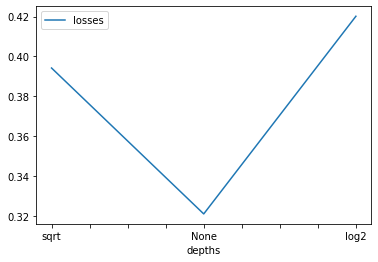

In [93]:

samplesplit=["sqrt",None,'log2']
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])
tdf.plot()

losses
depths          
5       0.379638
10      0.350890
15      0.334665
20      0.329449
25      0.324564
30      0.321627
35      0.321591
40      0.321685
45      0.321802
50      0.322003
55      0.321243
60      0.321787
65      0.321153
70      0.320962
75      0.322258
80      0.322264
85      0.321671
90      0.321176
95      0.321766
0.3209623498293637           losses
depths          
70      0.320962


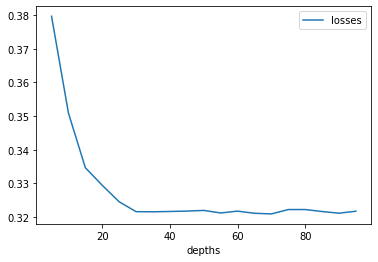

In [96]:

samplesplit=np.arange(5,100,5)
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=0.94,
        max_leaf_nodes  = d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])
tdf.plot()

losses
depths            
NaN       0.321620
balanced  0.397072
0.3216201559165736          losses
depths         
NaN     0.32162


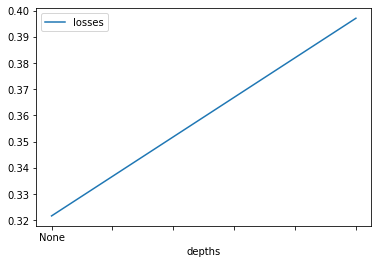

In [98]:

samplesplit=[None,"balanced"]
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=0.94,
        max_leaf_nodes  = 70,
        class_weight=d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])
tdf.plot()

losses
depths          
True    0.321848
False   0.321339
0.3213387477564965           losses
depths          
False   0.321339


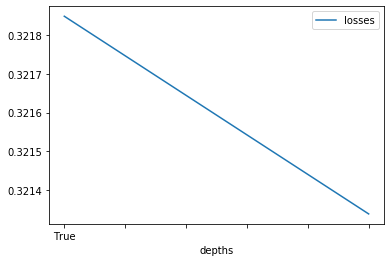

In [99]:

samplesplit=[True,False]
all_losses=[]
for d in samplesplit:
    # print("depth ",d)
    NFOLDS=5
    skf = StratifiedKFold(n_splits=NFOLDS)
    X=train.drop(target+id+categorical,axis=1).values
    y=train.target.values

    X_test=test.drop(id+target+categorical,axis=1).values
    preds=np.zeros((X_test.shape[0],))
    losses=[]
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # print(X_train.shape,X_val.shape)
        clf=DecisionTreeClassifier( criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=0.94,
        max_leaf_nodes  = 70,
        presort=d)
        clf.fit(X_train,y_train)
        pval=clf.predict_proba(X_val)[:,1]
        loss=log_loss(y_val,pval)
        losses.append(loss)
        
        pred_test=clf.predict_proba(X_test)[:,1]
        preds+=pred_test
    all_losses.append(np.mean(losses))
    preds=preds/NFOLDS
    sub=pd.DataFrame()
    sub["uid"]=test.reset_index()["uid"]

    sub["target"]= preds
    sub.head()
tdf=pd.DataFrame({"depths":samplesplit,"losses":all_losses}).set_index("depths")
print(tdf)
print(tdf.losses.min(),tdf[tdf["losses"]==tdf.losses.min()])
tdf.plot()

In [103]:
NFOLDS=5
skf = StratifiedKFold(n_splits=NFOLDS)
X=train.drop(target+id+categorical,axis=1).values
y=train.target.values

X_test=test.drop(id+target+categorical,axis=1).values
preds=np.zeros((X_test.shape[0],))
losses=[]
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # print(X_train.shape,X_val.shape)
    clf=DecisionTreeClassifier(criterion='gini',
        splitter='best',
        max_depth=8,
        min_samples_split=0.04,
        min_samples_leaf=33,
        max_features=0.94,
        max_leaf_nodes  = 70
        )
        
    clf.fit(X_train,y_train)
    pval=clf.predict_proba(X_val)[:,1]
    loss=log_loss(y_val,pval)
    losses.append(loss)
    
    pred_test=clf.predict_proba(X_test)[:,1]
    preds+=pred_test
print(np.mean(losses))
preds=preds/NFOLDS
sub=pd.DataFrame()
sub["uid"]=test.reset_index()["uid"]

sub["target"]= preds
sub.head()
sub.to_csv("submit_hyp_opt1.csv",index=None)

0.32158123707114694
